## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ImportError: bad magic number in 'get_data': b'\x03\xf3\r\n'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

6001


C:\Users\pocky\Anaconda3\envs\tf_gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\pocky\Anaconda3\envs\tf_gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


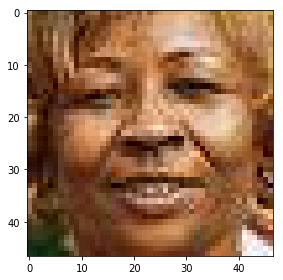

In [1]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import numpy
import matplotlib.image as mpimg # added
import csv
import os
import skimage

%matplotlib inline
from skimage.io import imshow

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    # Write your code for loading images and points here
    images_folder = os.path.join(dirname, "images")
    with open(os.path.join(dirname, "gt.csv")) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        #row_count = sum(1 for row in csv_reader)
        row_count = 6001
        print(row_count)
        #csv2 = csv.reader(csv_file, delimiter=',')
        points = numpy.zeros((row_count-1,28), dtype=float)
        images = numpy.zeros((row_count-1,100,100,3), dtype=float)
        xmask = numpy.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
        ymask = numpy.array([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1])
        
        line_count = 0
        for row in csv_reader: # csv_reader:
            if line_count == 0:
                pass # We do nothing
            else:
                # read file
                img = mpimg.imread(os.path.join(images_folder, row[0])) 
                height, width = img.shape[0], img.shape[1]

                imshow(img)
                img = skimage.transform.resize(img, (100, 100, 3))  
                images[line_count-1,:,:] = img
                row1 = list(map(int, row[1:]))
                row2 = xmask / height + ymask / width
                points[line_count-1,:] = row1 * row2 - 0.5
            line_count += 1
            if line_count % 100 == 0:
                print(line_count)
    
    return images, points

imgs, points = load_imgs_and_keypoints('data')


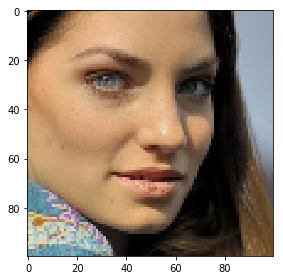

In [11]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

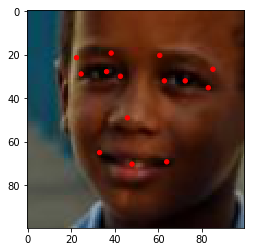

In [66]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    ax.imshow(img)
    
    patches = []
    for i in range(14):
        x, y = (points[2*i]+0.5)*100, (points[2*i+1]+0.5)*100
        circle = plt.Circle((x, y), 1, color='r')
        ax.add_patch(circle)
        
    for p in patches:
        ax.add_artist(p)

    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

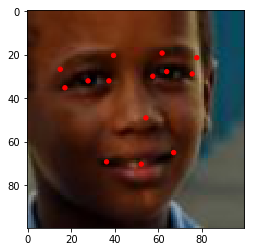

In [51]:
def flip_img(img, points):
    # Write your code for flipping here
    imgret = numpy.fliplr(img)
    ptsret = numpy.copy(points)

    swap = [3,2,1,0,9,8,7,6,5,4,10,13,12,11]
    for i in range(14):
        ptsret[2*i] = - points[2*swap[i]]
        ptsret[2*i+1] = points[2*swap[i]+1]

    return imgret, ptsret

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [52]:
# Write your code here
aug_imgs_train = []
aug_points_train = []

maxlen = len(imgs_train)
print(maxlen)
for i in range(maxlen):
    flimg, flpt = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_imgs_train.append(flimg)
    aug_points_train.append(points_train[i])
    aug_points_train.append(flpt)
    
print(len(aug_imgs_train))

5400
10800


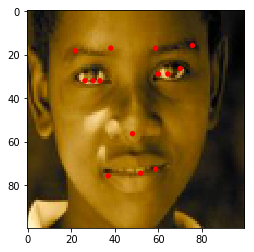

In [53]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

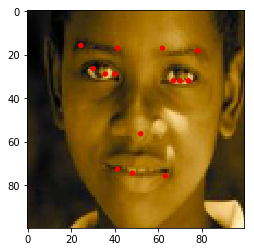

In [54]:
visualize_points(aug_imgs_train[5], aug_points_train[5]) # 3

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [88]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Activation, BatchNormalization, LeakyReLU
)

model = Sequential()

# Define here your model
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(100, 100, 3)))  
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same')) # , activation='tanh'
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same')) # , activation='tanh'
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())

# model.add(Dense(2500, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(250)) # , activation='relu'
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(28)) # , activation='tanh'
model.add(BatchNormalization())
model.add(Activation('tanh'))
# model.add(Dropout(0.25))

# model.add(Activation('relu'))

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [89]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mse',
              optimizer=adam, # sgd, 
              metrics=['accuracy'])

histo = model.fit(numpy.array(aug_imgs_train), numpy.array(aug_points_train),
          epochs=25,
          batch_size=256,
          validation_data = (imgs_val, points_val))
score = model.evaluate(imgs_val, points_val, batch_size=128)
print(score)


Train on 10800 samples, validate on 600 samples
Epoch 1/25
10800/10800 [==============================] - 16s 2ms/step - loss: 0.1459 - acc: 0.0743 - val_loss: 0.1820 - val_acc: 0.1167
Epoch 2/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0524 - acc: 0.2635 - val_loss: 0.0459 - val_acc: 0.5767
Epoch 3/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0478 - acc: 0.4481 - val_loss: 0.0550 - val_acc: 0.6117
Epoch 4/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0378 - acc: 0.5406 - val_loss: 0.0471 - val_acc: 0.4600
Epoch 5/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0354 - acc: 0.6209 - val_loss: 0.0286 - val_acc: 0.4617
Epoch 6/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0261 - acc: 0.7151 - val_loss: 0.0176 - val_acc: 0.7650
Epoch 7/25
10800/10800 [==============================] - 12s 1ms/step - loss: 0.0293 - acc: 0.7087 - val_loss: 0.0239 - val_acc: 

[0.015303025618195534, 0.8266666674613953]


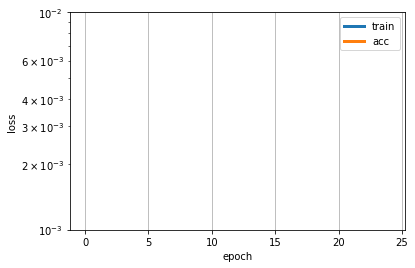

In [90]:
print(score)
loss = histo.history['loss']
acc  = histo.history['acc']

plt.plot(loss, linewidth=3, label='train')
plt.plot(acc, linewidth=3, label='acc')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log')
plt.show()

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[-0.29972738 -0.27231833 -0.10303073 -0.27966693  0.10839675 -0.2812953
  0.29651025 -0.27771607 -0.26054063 -0.18433274 -0.18414135 -0.1966155
 -0.11106417 -0.18068586  0.11412159 -0.18557726  0.18288581 -0.19913031
  0.25184935 -0.20055495  0.00396519  0.01987604 -0.14169039  0.18637757
 -0.00493296  0.19653274  0.14016105  0.18286394]
[-0.3108365  -0.20437262 -0.12452471 -0.26806084 -0.00380228 -0.29372624
  0.28612167 -0.32129278 -0.27946768 -0.15779468 -0.21387833 -0.1730038
 -0.13307985 -0.19201521  0.06178707 -0.21958175  0.15494297 -0.23193916
  0.26901141 -0.23669202 -0.09125475 -0.01425856 -0.16254753  0.1891635
 -0.02756654  0.17015209  0.17775665  0.15304183]
0


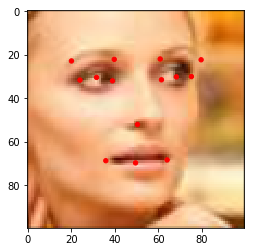

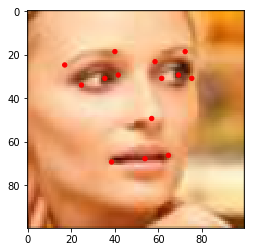

1


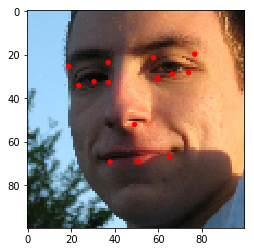

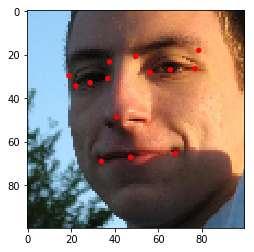

2


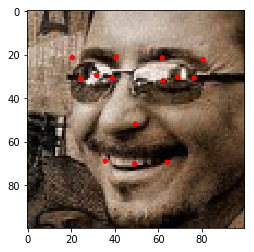

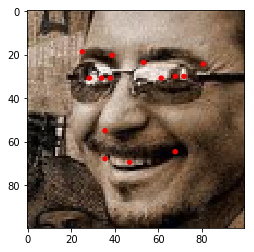

3


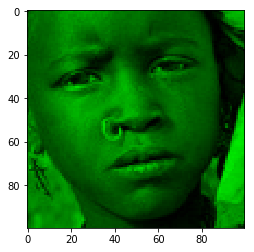

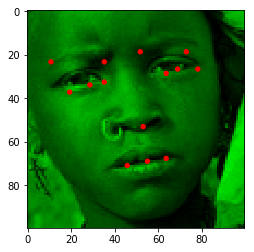

4


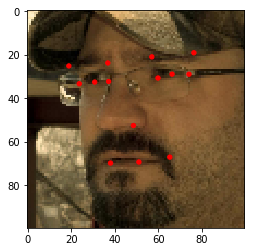

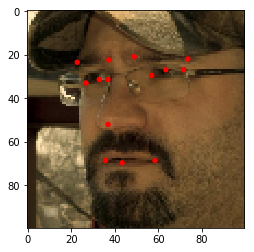

5


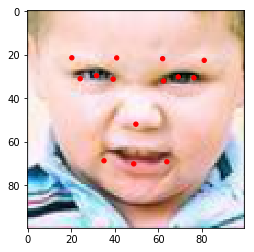

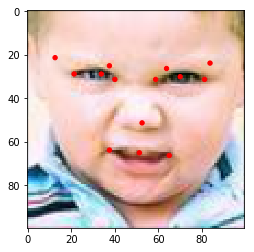

6


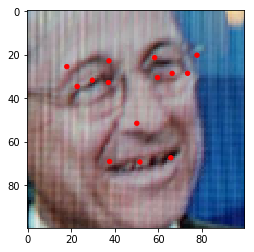

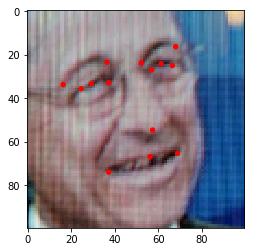

7


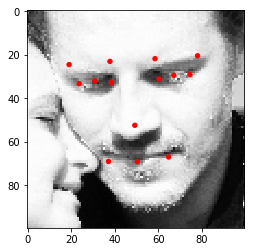

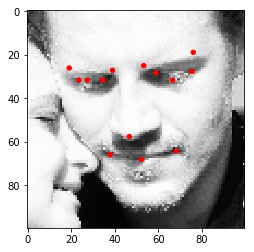

8


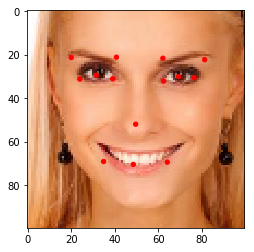

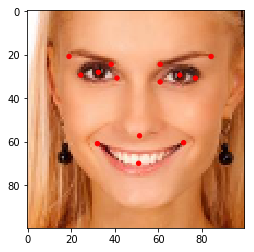

9


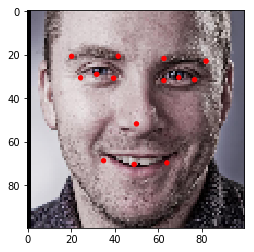

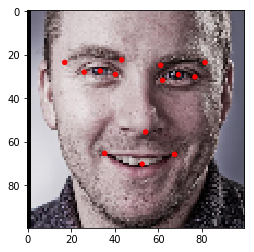

10


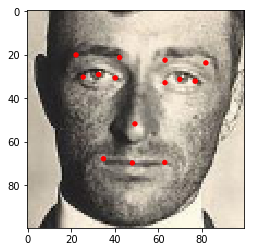

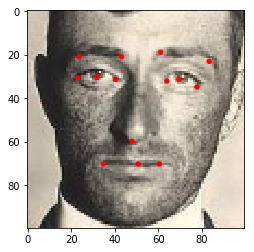

11


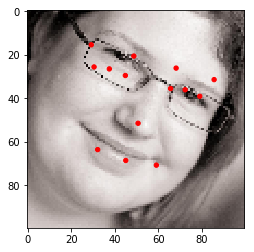

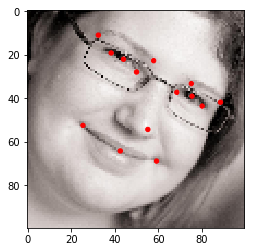

12


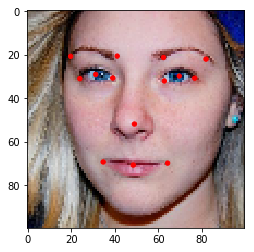

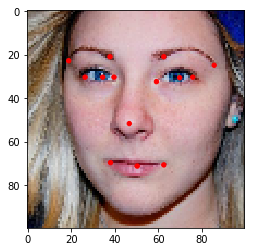

13


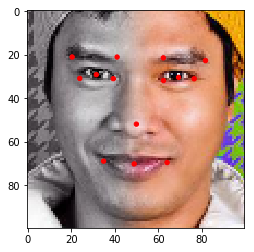

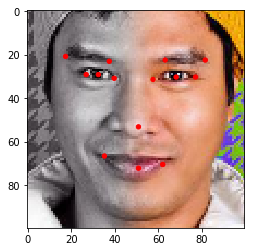

14


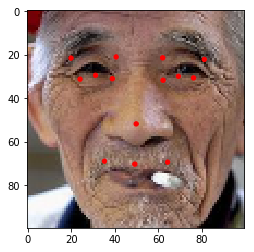

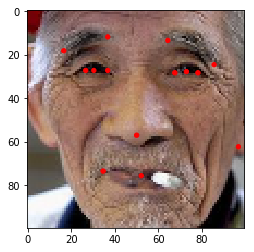

In [92]:
# Example of output
# pts_train_pred = model.predict(imgs_train)
# print(pts_train_pred[0])
# print(points_train[1])
# for i in range(10):
#     visualize_points(imgs_train[i], pts_train_pred[i]) # points_val
#     visualize_points(imgs_train[i], points_train[i]) # points_val

# Example of output
points_pred = model.predict(imgs_val)
print(points_pred[0])
print(points_val[1])
for i in range(15):
    print(i)
    visualize_points(imgs_val[i], points_pred[i]) # points_val
    visualize_points(imgs_val[i], points_val[i]) # points_val
# 